# CSCI 576 Final Project - Match Videos with Video Color Themes
### author: tong wang

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import shannon_entropy
import cv2
import math
from sys import getsizeof

## 1. read query videos and store them as list of image arrays of shape (288, 352, 3)
### Note: each query video takes about 30s to read and store

In [3]:
# read one rgb img
def readRGBimg(path_to_file, filename):
    byte_list = []
    with open(path_to_file+filename, "rb") as f:
        byte = f.read(1)
        while byte != b"":
            byte_list.append(byte)
            byte = f.read(1)

    img_data = np.zeros((288,352,3)).astype(np.uint8)
    height = 288
    width = 352
    ind = 0
    for y in range(height):
        for x in range(width):
            a=0
            r=int.from_bytes(byte_list[ind], byteorder='big')
            g=int.from_bytes(byte_list[ind+height*width], byteorder='big')
            b=int.from_bytes(byte_list[ind+height*width*2], byteorder='big')

            img_data[y][x][0] = r;
            img_data[y][x][1] = g;
            img_data[y][x][2] = b;

            ind+=1
    return img_data

# generate num_files # of filenames as format fnString+(001,002,...,150)+fileformat(.rgb)
def generateFileNames(num_files, fnString, fileformat):
    retFileNames = []
    for i in range(1, num_files + 1, 1):
        if (i<10):
            fnStr = "00"+str(i)
        elif (i<100):
            fnStr = "0"+str(i)
        else:
            fnStr = str(i)
        currRetName = fnString+fnStr+fileformat
        retFileNames.append(currRetName)
    return retFileNames

# reads a folder of query video images that of .rgb format
# returns list of 150 images array, each of shape (288, 352, 3)
def readRGBvideo(path_to_file, fnString):
    retImgsList = []
    filenamesList = generateFileNames(150, fnString, ".rgb")
    for i in range (150):
        retImgsList.append(readRGBimg(path_to_file,filenamesList[i]))
    return retImgsList

In [4]:
# read and store new uploaded SeenExactMatch query videos.
# takes about 90s. 30s each.

path_to_file = "./query_videos/SeenExactMatch/Q3/"
fnString = "Q3_"
Q3query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(Q3query)/64, "MB of memory")

path_to_file = "./query_videos/SeenExactMatch/Q4/"
fnString = "Q4_"
Q4query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(Q4query)/64, "MB of memory")

path_to_file = "./query_videos/SeenExactMatch/Q5/"
fnString = "Q5_"
Q5query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(Q5query)/64, "MB of memory")

Q3_ query video takes 22.75 MB of memory
Q4_ query video takes 22.75 MB of memory
Q5_ query video takes 22.75 MB of memory


In [5]:
# read and store new uploaded SeenInexactMatch query videos.
# takes about 90s. 30s each.

path_to_file = "./query_videos/SeenInexactMatch/HQ1/"
fnString = "HQ1_"
HQ1query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(HQ1query)/64, "MB of memory")

path_to_file = "./query_videos/SeenInexactMatch/HQ2/"
fnString = "HQ2_"
HQ2query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(HQ2query)/64, "MB of memory")

path_to_file = "./query_videos/SeenInexactMatch/HQ4/"
fnString = "HQ4_"
HQ4query = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(HQ4query)/64, "MB of memory")

HQ1_ query video takes 22.75 MB of memory
HQ2_ query video takes 22.75 MB of memory
HQ4_ query video takes 22.75 MB of memory


In [6]:
# read old query videos

path_to_file = "./query_videos/first/"
fnString = "first"
firstquery = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(firstquery)/64, "MB of memory")

path_to_file = "./query_videos/second/"
fnString = "second"
secondquery = readRGBvideo(path_to_file, fnString)
print(fnString,"query video takes",getsizeof(secondquery)/64, "MB of memory")

first query video takes 22.75 MB of memory
second query video takes 22.75 MB of memory


## 2. Utilities

- checkEntropy(inputImg) and checkInterframeEntropyDiff(img1, img2) are two conditions to calculate pallette of an image.
    - checkEntropy(inputImg) checks if an image have much information that worth extracting dominant colors (i.e. entropy is large enough). Current threshold is 0.1.
    - checkInterframeEntropyDiff(img1, img2) checks if two consecutive frames have much information change (i.e. difference of entropy btwn two frames is large enough). Current threshold is 0.05, which is very small. Normally, diff of entropy >1 means a **complete scene change**

- colorMetric(c1,c2) calculates distance between two colors. It's a low cost approximation that avoids converting RGB to CIE LUV color space. Source: http://www.compuphase.com/cmetric.htm

- colorMetricNorm(c1, c2) uses the same approximation with colorMetric(c1,c2), but normalized distance to be btwn [0,1]. A problem of using normalized distance is that the matching score went down in some cases.

- show|saveColorPalette() show or save a color theme w.r.t to each color's frequency. Current saved image size is 100x100. To adjust size, modify **plt.figure(figsize=(1, 1), dpi=100)**. Final size is figsize x dpi= (1, 1) x 100 = (100, 100)

In [123]:
# uncomment below if you want to tune parameters for entropy checking
# img1 = io.imread("./CS576FinalProjData/JPGdatabase_videos/JPGmusicvideo/musicvideo316.jpg")
# img2 = io.imread("./CS576FinalProjData/JPGdatabase_videos/JPGmusicvideo/musicvideo315.jpg")
# entropy1 = shannon_entropy(img1)
# entropyDiff = abs(shannon_entropy(img1) - shannon_entropy(img2))
# print(entropy1)
# print(entropyDiff)
# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)
# plt.show()

def checkEntropy(inputImg):
    entropy = shannon_entropy(inputImg)
    if (entropy > 0.1):
        return True
    else:
        return False

def checkInterframeEntropyDiff(img1, img2):
    entropyDiff = abs(shannon_entropy(img1) - shannon_entropy(img2))
    if (entropyDiff > 0.03):
        return True
    else:
        return False
    
# calculate color distance
c1 = np.array([255,255,255])
c2 = np.array([0,0,0])
def colorMetric(c1, c2):
    rmean = (c1[0]+c2[0])/2
    dr = c1[0]-c2[0]
    dg = c1[1]-c2[1]
    db = c1[2]-c2[2]
    dist = np.sqrt((2+rmean/256)*dr*dr + 4*dg*dg + (2+(255-rmean)/256)*db*db)
    # 765 is distance btwn white and black calculated use this metric.
    return dist/765


# normalized color distance to range 0 - 1. 
def colorMetricNorm(c1, c2):
    rmean = (c1[0]+c2[0])/2/256
    dr = (c1[0]-c2[0])/256
    dg = (c1[1]-c2[1])/256
    db = (c1[2]-c2[2])/256
    dist = np.sqrt((2+rmean)*dr*dr + 4*dg*dg + (2+(1-rmean))*db*db)
    # 765 is distance btwn white and black calculated use this metric.
    return dist

# show || save a color palette
# 576 = 288*2 = height*2 removes artifacts at bottom of image
def showColorPalette(palette, freq, title):
    rows = np.int_(576*freq)
    dom_patch = np.zeros(shape=(576, 576, 3), dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[i])
    plt.imshow(dom_patch)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def saveColorPalette(palette, freq, filename):
    rows = np.int_(576*freq)
    dom_patch = np.zeros(shape=(576, 576, 3), dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[i])
    plt.figure(figsize=(1, 1), dpi=100)
    plt.imshow(dom_patch)
    plt.axis('off')
    plt.savefig(filename, transparent=True)
    plt.show()

## 3. Get color descriptor for video.
### 3.1 implementations
#### strategy:
    video's color palette = []
    for all frames of a video
        if both checkEntropy and checkInterframeEntropyDiff holds
            extraxt 7 dominant colors for such frame with kmeans clustering
            append color palette of such frame to video's color palette
    find 5 dominant colors from video's color palette by doing kmeans clustering again
    
    Hence, each video's color descriptor is five colors

#### about cv2.kmeans
   - kmeans args: data, k, bestlabels, attempts, flags
   - Return values of cv2.kmeans: each palette has k colors. In a **palette**, each color has a lable, so **labels** var stores lables for colors. **counts** is a 1xk array that stores number of appearence for each color in palette by counting unique labels. **freqs** is 1x(k+1) array that stores relative frequency of color in percentage form.
   - in **criteria** cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER means stop the iteration when any of max_iter or eps is met
   - **flags** is how initial centers are taken, random center is normally used

In [124]:
def getFrameColorTheme(img):
    colorTheme = []
    n_colors_frame = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # data for kmeans. each row is a pixel RGB value
    pixels = np.float32(img.reshape(-1, 3))

    # find 3 dominant colors with k-clustering
    _, labels, palette = cv2.kmeans(pixels, n_colors_frame, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    # indices reflect the importance of colors in palette based on how big is the value in counts
    indices = np.argsort(counts)[::-1]
    
    # append colors based on reordered indices
    for i in range(n_colors_frame):
        colorTheme.append(palette[indices[i]])

    # calculates frequency of each color in palette
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    
    return np.asarray(colorTheme), freqs

# plt.imshow()

def getDataVideoColorDescriptor (path_to_data_dir, num_files, fnString):
    # generate filenames for reading local images
    filenames = generateFileNames(num_files, fnString, ".jpg")

    videoColorData = []
    for imgInd in range  (num_files):
        currImg = io.imread(path_to_data_dir+filenames[imgInd])
        if(checkEntropy(currImg) == False):
            continue
        # if not first and last frame, check entropy difference
        if (imgInd != 0 and imgInd != num_files - 1):
            nextImg = io.imread(path_to_data_dir+filenames[imgInd+1])
            if (checkInterframeEntropyDiff(nextImg, currImg) == False):
                continue
            
        currImgTheme, currFreq = getFrameColorTheme(currImg)
        videoColorData.append(currImgTheme)

    # reshape data so that it can be used by cv2.kmeans
    videoColorData = np.asarray(videoColorData)
    videoColorData = videoColorData.reshape(-1,3)
    
    # do k-clustering again wrt videoColorData (complete video), pick 5 most dominant colors as color theme
    n_colors_video = 5
    # set epsilon to .01 so that it is more accurate when do kmeans on compele videos
    criteria_video = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .01)
    flags_video = cv2.KMEANS_RANDOM_CENTERS

    _, labels_video, palette_video = cv2.kmeans(videoColorData, n_colors_video, None, criteria_video, 10, flags_video)
    _, counts_video = np.unique(labels_video, return_counts=True)
    # reorder colors based on counts
    indices_video = np.argsort(counts_video)[::-1]
    ordered_palette = np.zeros(shape=palette_video.shape, dtype=np.float32)
    for i in range(n_colors_video):
        ordered_palette[i] = palette_video[indices_video[i]]
    freqs_video = np.cumsum(np.hstack([[0], counts_video[indices_video]/counts_video.sum()]))
    return ordered_palette, freqs_video

def getQueryVideoColorDescriptor(list_of_frames):
    videoColorData = []
    for imgInd in range  (len(list_of_frames)):
        currImg = list_of_frames[imgInd]
    
        if(checkEntropy(currImg) == False):
            continue
        if (imgInd!=0 and imgInd != len(list_of_frames) - 1):
            nextImg = list_of_frames[imgInd+1]
            if (checkInterframeEntropyDiff(nextImg, currImg) == False):
                continue

        currImgTheme, currFreq = getFrameColorTheme(currImg)
        videoColorData.append(currImgTheme)

    # reshape data so that it can be used by cv2.kmeans
    videoColorData = np.asarray(videoColorData)
    videoColorData = videoColorData.reshape(-1,3)
    
    # do k-clustering again wrt videoColorData (complete video), pick 5 most dominant colors as color theme
    n_colors_video = 5
    # set epsilon to .01 so that it is more accurate when do kmeans on compele videos
    criteria_video = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .01)
    flags_video = cv2.KMEANS_RANDOM_CENTERS

    _, labels_video, palette_video = cv2.kmeans(videoColorData, n_colors_video, None, criteria_video, 10, flags_video)
    _, counts_video = np.unique(labels_video, return_counts=True)
    # reorder colors based on counts
    indices_video = np.argsort(counts_video)[::-1]
    ordered_palette = np.zeros(shape=palette_video.shape, dtype=np.float32)
    for i in range(n_colors_video):
        ordered_palette[i] = palette_video[indices_video[i]]
    freqs_video = np.cumsum(np.hstack([[0], counts_video[indices_video]/counts_video.sum()]))
    return ordered_palette, freqs_video
# pal, freq = getQueryVideoColorDescriptor(testimgList)

#### 3.1.1 extract color themes for all frames without entropy checking
- return num_filesx5x3 array of colors
- note: uses generateFileNames() and getFrameColorTheme()

(600, 5, 3)


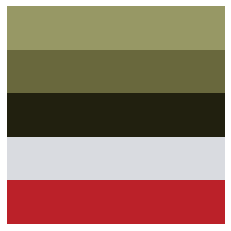

In [136]:
def getFbyFColorDesc (path_to_data_dir, num_files, fnString):
    # generate filenames for reading local images
    colorThemes = []
    filenames = generateFileNames(num_files, fnString, ".jpg")

    videoColorData = []
    for imgInd in range  (num_files):
        currImg = io.imread(path_to_data_dir+filenames[imgInd])
        currImgTheme, _ = getFrameColorTheme(currImg)
        colorThemes.append(currImgTheme)
    return np.asarray(colorThemes)

# example use:
numfiles = 600
testDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGflowers/"
testFnString = "flowers"
testPalette = getFbyFColorDesc(testDirPath, numfiles, testFnString)
print(testPalette.shape)

# testFreq = np.array([0,0.2,0.4,0.6,0.8,1.0])
# showAndSaveVideoColorPalette(testPalette[5], testFreq)

### 3.2 get color descriptor for query videos
#### note: takes 96s for 8 queries. 12s each

In [125]:
query1palette, query1freq = getQueryVideoColorDescriptor(firstquery)
query2palette, query2freq = getQueryVideoColorDescriptor(secondquery)

queryQ3palette, queryQ3freq = getQueryVideoColorDescriptor(Q3query)
queryQ4palette, queryQ4freq = getQueryVideoColorDescriptor(Q4query)
queryQ5palette, queryQ5freq = getQueryVideoColorDescriptor(Q5query)

queryHQ1palette, queryHQ1freq = getQueryVideoColorDescriptor(HQ1query)
queryHQ2palette, queryHQ2freq = getQueryVideoColorDescriptor(HQ2query)
queryHQ4palette, queryHQ4freq = getQueryVideoColorDescriptor(HQ4query)

### 3.3 get color descriptor for database videos

In [126]:
numfiles = 600

flowersDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGflowers/"
fnString = "flowers"
flowersPalette, flowersFreq = getDataVideoColorDescriptor(flowersDirPath, numfiles, fnString)
print(fnString,"done")

interviewDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGinterview/"
fnString = "interview"
interviewPalette, interviewFreq = getDataVideoColorDescriptor(interviewDirPath, numfiles, fnString)
print(fnString,"done")

movieDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGmovie/"
fnString = "movie"
moviePalette, movieFreq = getDataVideoColorDescriptor(movieDirPath, numfiles, fnString)
print(fnString,"done")

musicvideoDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGmusicvideo/"
fnString = "musicvideo"
musicvideoPalette, musicvideoFreq = getDataVideoColorDescriptor(musicvideoDirPath, numfiles, fnString)
print(fnString,"done")

sportsDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGsports/"
fnString = "sports"
sportsPalette, sportsFreq = getDataVideoColorDescriptor(sportsDirPath, numfiles, fnString)
print(fnString,"done")

starcraftDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGstarcraft/"
fnString = "starcraft"
starcraftPalette, starcraftFreq = getDataVideoColorDescriptor(starcraftDirPath, numfiles, fnString)
print(fnString,"done")

trafficDirPath = "./CS576FinalProjData/JPGdatabase_videos/JPGtraffic/"
fnString = "traffic"
trafficPalette, trafficFreq = getDataVideoColorDescriptor(trafficDirPath, numfiles, fnString)
print(fnString,"done")

flowers done
interview done
movie done
musicvideo done
sports done
starcraft done
traffic done


## 4. Calculate color theme matching score

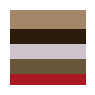

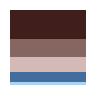

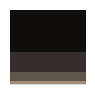

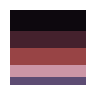

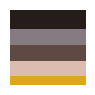

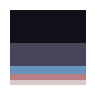

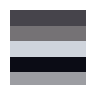

exact match: 


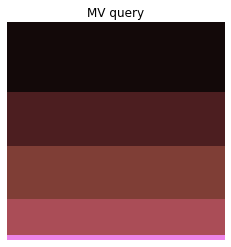

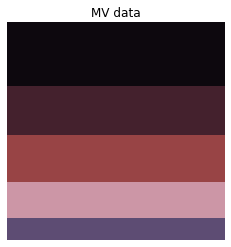

MV against flowers matching score: 79.21 %
MV against interview matching score: 78.42 %
MV against movie matching score: 82.28 %
MV against MV matching score: 89.14 %
MV against sports matching score: 78.65 %
MV against starcraft matching score: 76.51 %
MV against traffic matching score: 77.14 %


Sports against flowers matching score: 78.07 %
Sports against interview matching score: 76.34 %
Sports against movie matching score: 74.55 %
Sports against MV matching score: 73.83 %
Sports against sports matching score: 92.49 %
Sports against starcraft matching score: 74.93 %
Sports against traffic matching score: 77.6 %


Traffic against flowers matching score: 79.72 %
Traffic against interview matching score: 75.73 %
Traffic against movie matching score: 83.44 %
Traffic against MV matching score: 77.61 %
Traffic against sports matching score: 82.23 %
Traffic against starcraft matching score: 81.45 %
Traffic against traffic matching score: 92.22 %


Starcraft against flowers matching score:

In [168]:
def calcColorMatchScore(palette1, palette2, pal1freq):
    totalMatchScore = 0
    contribution = np.zeros(5)
    for i in range(5):
        contribution[i] = pal1freq[i+1]-pal1freq[i]
    for i in range(5):
        bestMatchScore = 0
        for j in range(5):
#             currColorDist = colorMetric(palette1[i], palette2[j])
            currColorDist = colorMetricNorm(palette1[i], palette2[j])
            # calculate matching score
            currMatchScore = 1/(1+currColorDist)
            if (currMatchScore > bestMatchScore):
                bestMatchScore = currMatchScore
        totalMatchScore += bestMatchScore *contribution[i]
    return np.around(totalMatchScore*100, decimals=2)

def matchQueryWithDatabase(query_name, query_palette, query1freq):
    print(query_name, "against flowers matching score:", calcColorMatchScore(query_palette, flowersPalette, query1freq),"%")
    print(query_name, "against interview matching score:", calcColorMatchScore(query_palette, interviewPalette, query1freq),"%")
    print(query_name, "against movie matching score:", calcColorMatchScore(query_palette, moviePalette, query1freq),"%")
    print(query_name, "against MV matching score:", calcColorMatchScore(query_palette, musicvideoPalette, query1freq),"%")
    print(query_name, "against sports matching score:", calcColorMatchScore(query_palette, sportsPalette, query1freq),"%")
    print(query_name, "against starcraft matching score:", calcColorMatchScore(query_palette, starcraftPalette, query1freq),"%")
    print(query_name, "against traffic matching score:", calcColorMatchScore(query_palette, trafficPalette, query1freq),"%")
    print("\n")


# saveColorPalette(flowersPalette, flowersFreq, "flowers_data_colorTheme.jpg")
# saveColorPalette(interviewPalette, interviewFreq, "interview_data_colorTheme.jpg")
# saveColorPalette(moviePalette, movieFreq, "movie_data_colorTheme.jpg")
# saveColorPalette(musicvideoPalette, musicvideoFreq, "mv_data_colorTheme.jpg")
# saveColorPalette(sportsPalette, sportsFreq, "sports_data_colorTheme.jpg")
# saveColorPalette(starcraftPalette, starcraftFreq, "starcraft_data_colorTheme.jpg")
# saveColorPalette(trafficPalette, trafficFreq, "traffic_data_colorTheme.jpg")
    
print("exact match: ")

showColorPalette(query1palette, query1freq, "MV query")
showColorPalette(musicvideoPalette, musicvideoFreq, "MV data")
matchQueryWithDatabase("MV",query1palette, query1freq)

matchQueryWithDatabase("Sports",query2palette, query2freq)
matchQueryWithDatabase("Traffic",queryQ3palette, queryQ3freq)
matchQueryWithDatabase("Starcraft",queryQ4palette, queryQ4freq)
matchQueryWithDatabase("Flower",queryQ5palette, queryQ5freq)

print("inexact match: ")
matchQueryWithDatabase("Look like a movie",queryHQ1palette, queryHQ1freq)
matchQueryWithDatabase("Cars with hight motion",queryHQ2palette, queryHQ2freq)
matchQueryWithDatabase("Other flowers",queryHQ4palette, queryHQ4freq)
